### Building a Deep Learning Model on the Auto-MPG Dataset

The dataset being used is the Auto-Mpg dataset from the UCI Machine Learning Repository. It's a relatively old data set, circa 1993.

I am writing this notebook using the reference book Applied Deep Learning and Computer Vision for Self-Driving Cars which can be found [here](https://learning.oreilly.com/library/view/applied-deep-learning/9781838646301/).

In [3]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from __future__ import absolute_import, division, print_function, unicode_literals


In [13]:
# Import the Auto-Mpg dataset and store a copy of the raw data to use
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names =['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()

# Drop NA values
dataset = dataset.dropna()

# View a sample of randomly selected entries.
# Notice the Origin column which we'll acount for in the next cell.
dataset.sample(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
331,33.8,4,97.0,67.0,2145.0,18.0,80,3
202,17.5,6,258.0,95.0,3193.0,17.8,76,1
177,23.0,4,115.0,95.0,2694.0,15.0,75,2
152,19.0,6,225.0,95.0,3264.0,16.0,75,1
210,19.0,6,156.0,108.0,2930.0,15.5,76,3
223,15.5,8,318.0,145.0,4140.0,13.7,77,1
165,20.0,8,262.0,110.0,3221.0,13.5,75,1
65,14.0,8,351.0,153.0,4129.0,13.0,72,1
373,24.0,4,140.0,92.0,2865.0,16.4,82,1
368,27.0,4,112.0,88.0,2640.0,18.6,82,1


In [14]:
# Origin in this dataset is a 1, 2, or 3 corresponding to USA, Europe, Japan, respectively.
# Pop "Origin" from the dataset and then break these out into their own columns using a one-hot encoding scheme.

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

dataset.sample(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
202,17.5,6,258.0,95.0,3193.0,17.8,76,1.0,0.0,0.0
43,13.0,8,400.0,170.0,4746.0,12.0,71,1.0,0.0,0.0
309,41.5,4,98.0,76.0,2144.0,14.7,80,0.0,1.0,0.0
303,31.8,4,85.0,65.0,2020.0,19.2,79,0.0,0.0,1.0
50,28.0,4,116.0,90.0,2123.0,14.0,71,0.0,1.0,0.0
135,18.0,6,225.0,105.0,3613.0,16.5,74,1.0,0.0,0.0
210,19.0,6,156.0,108.0,2930.0,15.5,76,0.0,0.0,1.0
143,26.0,4,97.0,78.0,2300.0,14.5,74,0.0,1.0,0.0
258,20.6,6,231.0,105.0,3380.0,15.8,78,1.0,0.0,0.0
173,24.0,4,119.0,97.0,2545.0,17.0,75,0.0,0.0,1.0


In [22]:
# Break up the data into training and test sets

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


C:\Python38\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


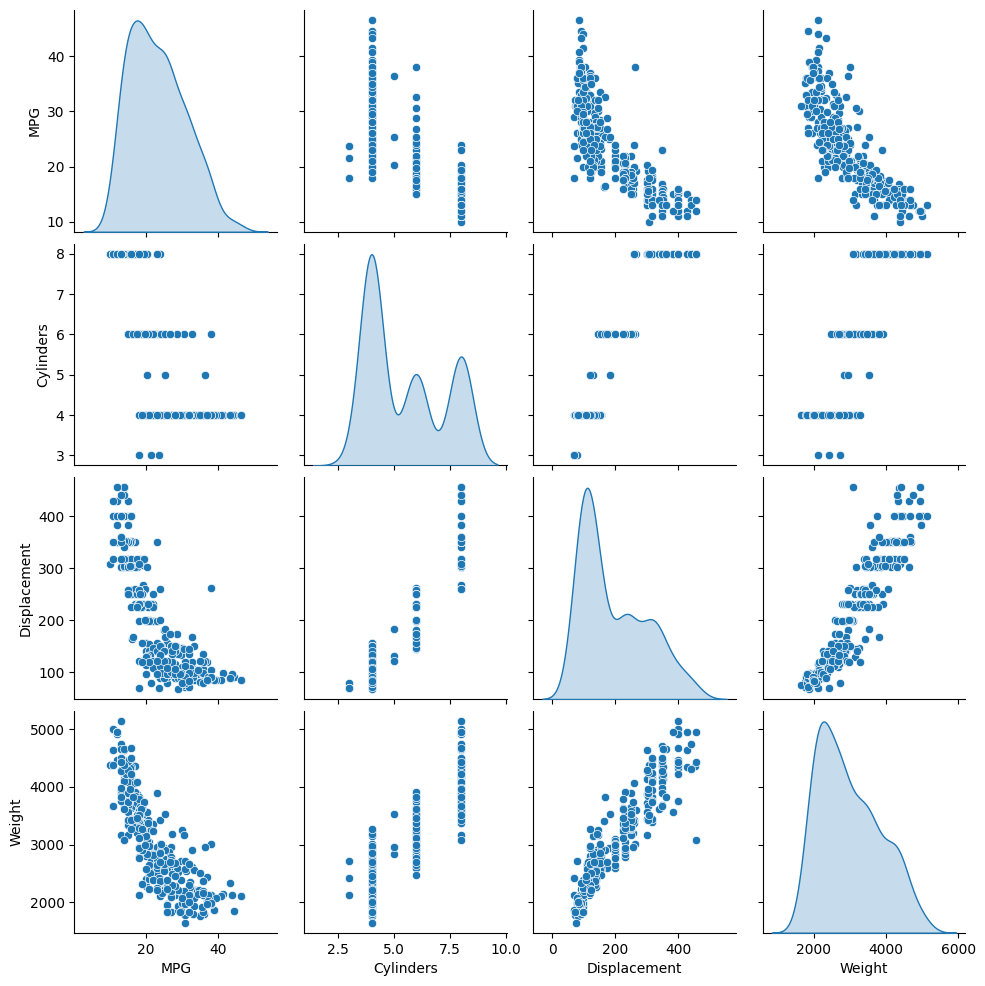

In [23]:
# Visualize the distribution of selected features using Kernel Density Estimation 
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [32]:
# Get details (e.g. count, mean, max) from the training data
train_stats = train_dataset.describe()
train_stats.pop('MPG')

# Transpose the data so that features become the rows
train_stats = train_stats.transpose()
print(train_stats)


              count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe       

In [33]:
# Pull out the MPG labels
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

train_dataset.sample(5)

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
63,8,400.0,175.0,4385.0,12.0,72,1.0,0.0,0.0
240,4,97.0,78.0,2190.0,14.1,77,0.0,1.0,0.0
196,4,98.0,60.0,2164.0,22.1,76,1.0,0.0,0.0
320,4,119.0,92.0,2434.0,15.0,80,0.0,0.0,1.0
84,4,97.0,88.0,2100.0,16.5,72,0.0,0.0,1.0


In [35]:
# Check the training and test labels
print(train_labels.head())
print(test_labels.head())

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
Name: MPG, dtype: float64
9     15.0
25    10.0
28     9.0
31    25.0
33    19.0
Name: MPG, dtype: float64


In [41]:
# Helper method to standardized data. Still a bit of confusion for me on the differences between standardization and normalization
def normalize(x):
    return (x - train_stats['mean']) / train_stats['std']

In [38]:
normed_train_data = normalize(train_dataset)
normed_test_data = normalize(test_dataset)

In [40]:
# Define a method to build a Sequential model using Keras
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mean_squared_error',
                    optimizer=optimizer,
                    metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [42]:
# Create a model instance
model = build_model()

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4865 (19.00 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Print a single dot for each completed epoch - this will be used during training as it progresses.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [46]:
EPOCHS = 1000

In [47]:
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [48]:
# Check loss, mean absolute error, mean square error, val loss, val mean squared error and val mean absolute error
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.894223,1.039105,2.894223,9.371237,2.338148,9.371237,995
996,2.444278,0.943942,2.444278,9.302721,2.285363,9.302721,996
997,2.381377,0.920633,2.381377,9.996067,2.358403,9.996067,997
998,2.532441,0.968681,2.532441,9.859242,2.357037,9.859242,998
999,2.606209,1.038261,2.606209,9.423925,2.288271,9.423925,999


In [53]:
# Method to Plot loss
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error', color='green')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error', color='purple')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error', color='green')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error', color='purple')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

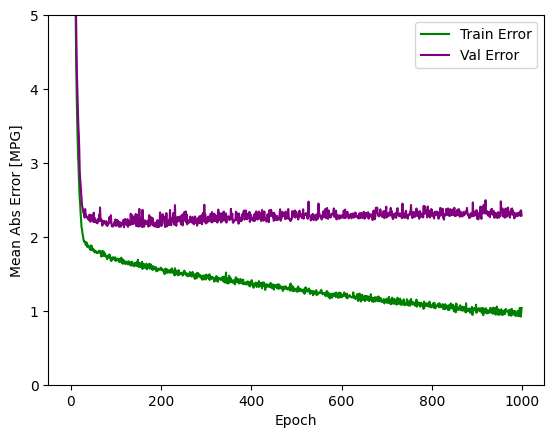

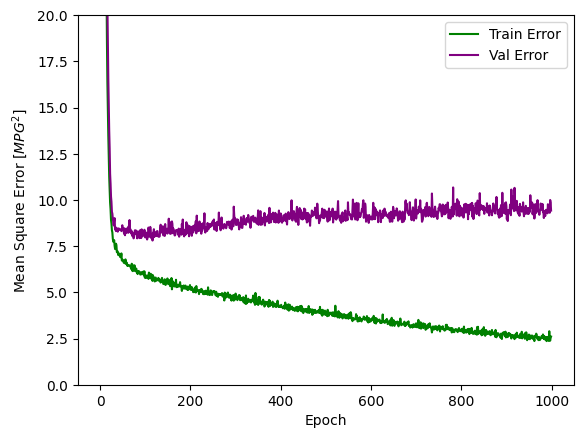

In [54]:
plot_history(history)

3/3 [==============================] - 0s 0s/step


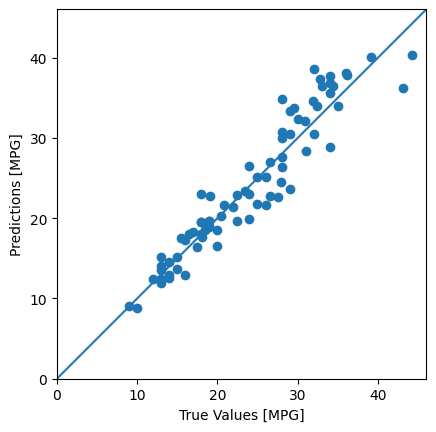

In [55]:
# Test out the predictions on the test set using the trained model
test_predictions = model.predict(normed_test_data).flatten()
 
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

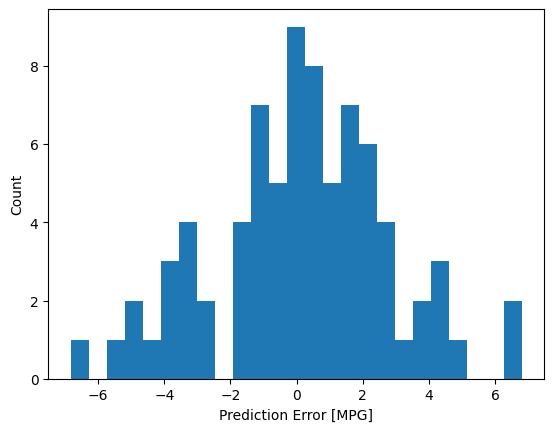

In [56]:
# Plot the loss for the test predictions
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")